# HumanBreastCancer (Xenium) Analysis Tutorial

<p style="color:#1E90FF;">
<b>Data availability:</b> All processed spatial transcriptomics datasets are publicly available on Zenodo:
<a href="https://doi.org/10.5281/zenodo.17522268" style="color:#1E90FF; text-decoration:underline;">
https://doi.org/10.5281/zenodo.17522268
</a>
</p>

In [1]:
from models.SCILD_main import *
from models.help_func import create_LRDatabase_D
import scanpy as sc
import squidpy as sq
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

## Import data

In [ ]:
# data_name = 'DCIS1'
data_name = 'DCIS2'

In [3]:
adata = sc.read_h5ad(f'./data/HumanBreastCancerXenium_adata_processed_{data_name}.h5ad') 
adata

AnnData object with n_obs × n_vars = 4794 × 311
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'celltype', 'in_roi', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'celltype_colors', 'log1p', 'spatialdata_attrs'
    obsm: 'spatial'

Please specify a valid `library_id` or set it permanently in `adata.uns['spatial']`


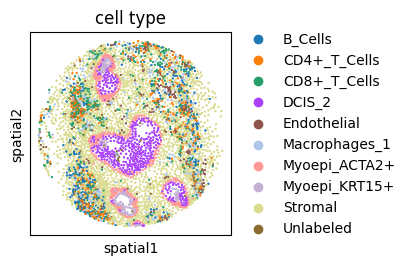

In [4]:
sq.pl.spatial_scatter(adata, shape=None, size=1, color=["celltype"], figsize=(4, 4), title='cell type')

## Create L-R database

In [5]:
LRDatabase_D = create_LRDatabase_D(
    adata,
    min_cell_pct=0.001,
    database='CellChat',
    species='human'
)

In [6]:
LRDatabase_D

receptor,CXCR4,EDNRB,SDC4
ligand,,,
CXCL12,1.0,0.0,0.0
EDN1,0.0,1.0,0.0
PTN,0.0,0.0,1.0


## Run SCILD

In [7]:
CCCProb = SCILD(adata=adata,
                LRDatabase_D=LRDatabase_D,
                neighbor_k=20,
                alpha_q=0.1,
                alpha_f=0.1,
                alpha_g=0.1,
                niter_max=100,
                eps=1e-4,
                verbose=True,
                plot_error=True
                )
CCCProb.preparing()
nl = CCCProb.nl
nr = CCCProb.nr
ns = CCCProb.ns
print('The number of ligand is: ' + str(nl))
print('The number of receptor is: ' + str(nr))
print('The number of spot is: ' + str(ns))

*************Preparing*************
neighbor_k: 20
The number of ligand is: 3
The number of receptor is: 3
The number of spot is: 4794



*************Solving*************
The relative error is: 0.05192437992530585
The relative error is: 0.028486725024731874
The relative error is: 0.02025789702458264
The relative error is: 0.01596560021255227
The relative error is: 0.013300769537026701
The relative error is: 0.011476945051522578
The relative error is: 0.010126550089702422
The relative error is: 0.009080509156811996
The relative error is: 0.008242905085682877
The relative error is: 0.007554971082628599

 The final relative error is: 0.007554971082628599
The total iteration step is: 100


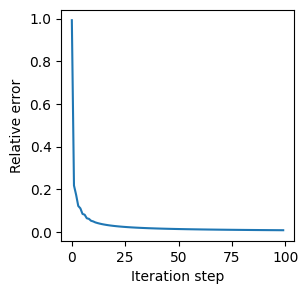

In [8]:
mu0 = np.random.random(nl * ns).reshape(-1, 1)
v0 = np.random.random(nr * ns).reshape(-1, 1)
CCCProb.solving_optimization(mu0, v0)

In [9]:
CCCProb.adata

AnnData object with n_obs × n_vars = 4794 × 311
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'celltype', 'in_roi', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'celltype_colors', 'log1p', 'spatialdata_attrs'
    obsm: 'spatial', 'sum-sender-Q', 'sum-sender-P', 'sum-receiver'

## Extract LR CCC

In [10]:
CCCProb.query_all_LR()

In [11]:
CCCProb.tensor_P.shape

(4794, 4794, 3, 3)

In [12]:
res_dict = tensor_to_method_result(CCCProb.tensor_P, 
                                   list(CCCProb.LRDatabase_D.index), 
                                   list(CCCProb.LRDatabase_D.columns))
len(res_dict)

9

In [13]:
res_dict = filter_method_result_by_LR_database(res_dict, CCCProb.LRDatabase_D)
len(res_dict)

3

In [14]:
import pickle
with open(f"./results/HumanBreastCancerXenium_{data_name}_SCILD_result.pkl", "wb") as f:
    pickle.dump(res_dict, f)

## Visualization

select L-Rs to show (spatial)

In [15]:
CCC_df = CCCProb.compute_TSSR()
CCC_adata = sc.AnnData(CCC_df)
CCC_adata.obsm['spatial'] = adata.obsm['spatial']
CCC_adata

AnnData object with n_obs × n_vars = 4794 × 6
    obsm: 'spatial'

In [16]:
CCCProb.adata.obs[CCC_df.columns] = CCC_df
CCCProb.adata.obs.head()

,cell_id,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,region,celltype,in_roi,n_genes,CXCL12->CXCR4 (S),CXCL12->CXCR4 (R),EDN1->EDNRB (S),EDN1->EDNRB (R),PTN->SDC4 (S),PTN->SDC4 (R)
4355,4356,267,0,0,267,232.509531,30.345000,cell_circles,Stromal,True,82,1.926135,1.369234e-07,7.178474e-47,7.769933e-10,5.546523e-49,8.435185e-08
4356,4357,329,0,0,329,344.722813,71.662969,cell_circles,Stromal,True,87,2.312519,4.810222e-08,9.695835e-47,4.866745e-08,6.791721e-01,1.305466e-09
4357,4358,101,0,0,102,90.131875,5.870312,cell_circles,Stromal,True,33,2.902932,1.510811e-07,6.337316e-47,1.047398e-11,8.029149e-48,1.195343e-08
4358,4359,131,0,0,131,77.036563,13.005000,cell_circles,Stromal,True,48,3.503055,2.246962e-07,8.164045e-47,1.017825e-15,8.380267e-48,9.340701e-08
4389,4390,350,0,0,350,443.344063,30.164375,cell_circles,Stromal,True,93,3.758691,8.074165e-08,1.258750e-46,3.617075e-02,2.644387e-01,3.387314e-19


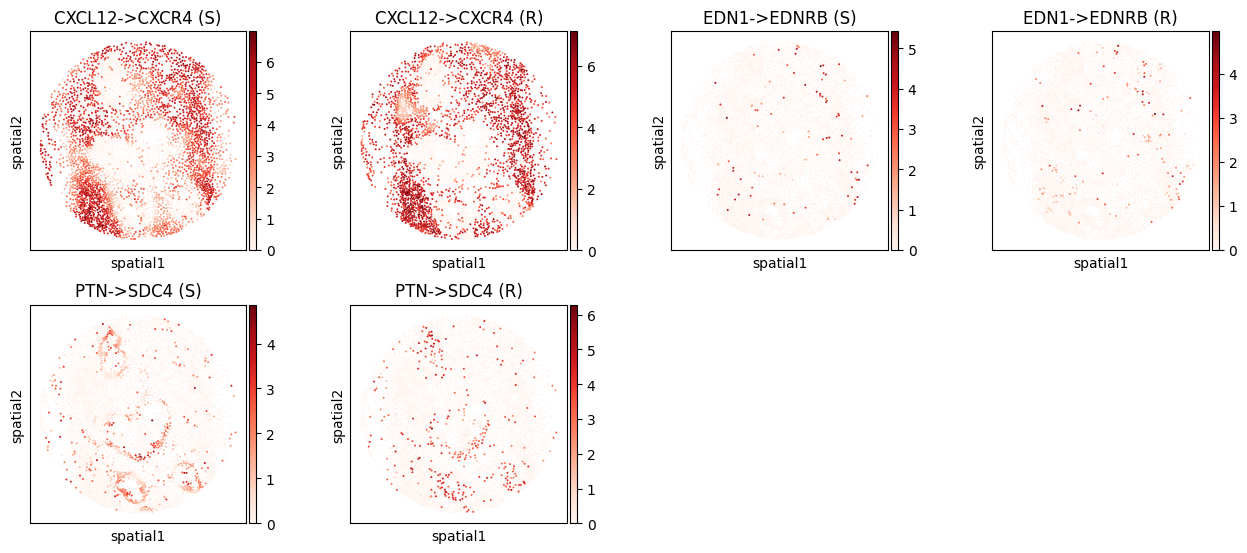

In [17]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.spatial(CCCProb.adata, spot_size=10, color=CCCProb.adata.obs.columns[-6:], cmap='Reds', img_key=None)

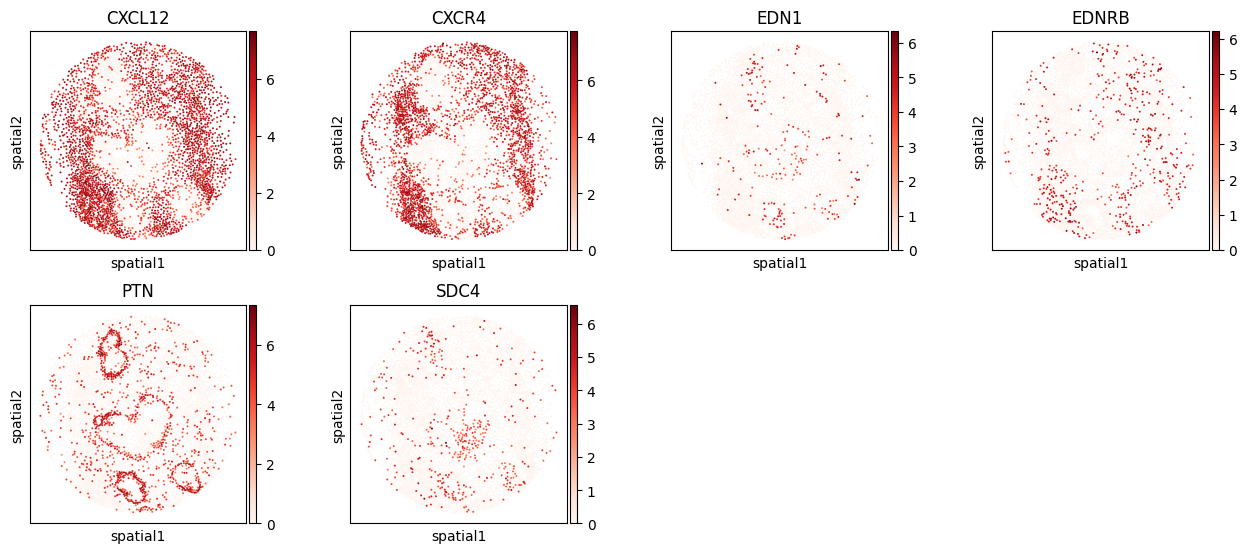

In [18]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.spatial(CCCProb.adata, spot_size=10, color=['CXCL12', 'CXCR4', 'EDN1', 'EDNRB', 'PTN', 'SDC4'], cmap='Reds', img_key=None)